In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
import statsmodels.api as sm
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# **Intro**


This analysis focuses on the payment data of a digital product in Nebula, specifically related to period tracking. Our team of analysts was tasked with uncovering insights from transaction-level data collected throughout 2022. The core objective is to identify patterns, trends, and potential issues within the payment funnel and provide actionable recommendations to support the go-to-market strategy for a new product.  

Key goals of this analysis include:   

- Understanding user behavior across the purchase lifecycle: from the first payment attempt to repeat transactions.   
- Detecting anomalies and failures in the payment process, especially across countries, card types, and banks.
- Evaluating retention and churn patterns to assess long-term user value.
- Estimating key business metrics such as conversion rates, average revenue per user (ARPU), and transaction success rates across regions.
- The final aim is to deliver a data-driven foundation for business decisions that will improve conversion, reduce failed transactions, and inform a sustainable unit economics strategy before market expansion.

# **Data Overview**

The dataset contains individual payment attempts, with each row representing a single transaction. The structure includes the following columns:   

- **order_id:** Unique identifier for the transaction.
- **event_time:** Timestamp when the transaction occurred.
- **user_id:** Unique identifier for the user making the transaction.
- **price:** The monetary amount of the transaction.
- **payment_number:** The sequence number of the user's transaction (e.g. first, second, etc.).
- **transaction_status:** Indicates whether the transaction was successful (1) or failed (0).
- **card_brand:** The card network used (e.g., VISA, MASTERCARD).
- **card_type:** Type of card used (e.g., CREDIT, DEBIT, PREPAID).
- **bank_name:** Name of the issuing bank.
- **error_type:** Reason for transaction failure (if any).
- **currency:** Currency in which the transaction was made.
- **card_country:** ISO 3166-1 alpha-3 country code of the card issuer.  
An initial scan of the data helped identify transaction patterns, success rates, and differences in user behavior across countries, card types, and banks.

# **Methodology**

The analysis was conducted in four key stages:   

- **Data Cleaning**      
Standardized date formats, country codes, and bank names.
Filtered for successful and failed transactions separately.
- **Exploratory Analysis**   
Analyzed user behavior, churn, and repeat purchases.
Compared patterns across countries, card brands, and banks.
    - **Insights & Recommendations**
Identified churn risks, bank/card issues, and high-value segments.
    - Suggested strategies for retention and failed transaction recovery.
- **Conclusion**   
Summarized key findings and their impact on business growth.

# **Results of the analysis:**

# **1. Dataset cleaning**

In [4]:
data = pd.read_csv("test_payment_data.csv")

missing_values_full = data.isnull().sum()
missing_values_full

#                          0
order_id                   0
event_time                 0
user_id                    0
price                      0
payment_number             0
transaction_status         0
card_brand                 0
card_type                770
bank_name               2009
error_type            253365
currency                   0
card_country             527
dtype: int64

**Null in the dataset in the variable means error_type no errors, so we can replace it with 0 for better further work**

In [5]:
columns_to_fill = ["error_type"]
for col in columns_to_fill:
    data[col].fillna(0, inplace=True)

In [6]:
missing_values_full = data.isnull().sum()
missing_values_full

#                        0
order_id                 0
event_time               0
user_id                  0
price                    0
payment_number           0
transaction_status       0
card_brand               0
card_type              770
bank_name             2009
error_type               0
currency                 0
card_country           527
dtype: int64

**We can replace the missing bank_name with a new category - Unknown**

In [7]:
data['bank_name'].fillna('Unknown', inplace=True)

**From our personal experience, it's easier to work with binary values than with words, so we change fail to 0 and success to 1 in the variable transaction_status**

In [8]:
data['transaction_status'] = data['transaction_status'].map({'fail': 0, 'success': 1})

**Now we will replace the remaining null values with new categories, we have a small % of missing data, so we can do it this way**

In [9]:
data['card_country'].fillna('Unknown', inplace=True)

In [10]:
data['card_type'].fillna('Unknown', inplace=True)

In [11]:
print(data.isnull().sum())

#                     0
order_id              0
event_time            0
user_id               0
price                 0
payment_number        0
transaction_status    0
card_brand            0
card_type             0
bank_name             0
error_type            0
currency              0
card_country          0
dtype: int64


**As you can see, there are no missing data**

We decided to check for duplicates in important values ​​that must be unique. Namely order_id. By checking order_id, we found that there were 1098 rows with the same order_id. By checking other values, we found that all the values ​​in these rows were also duplicates. So we removed these values.

In [12]:
total_orders = data['order_id'].count()
unique_orders = data['order_id'].nunique()
duplicate_orders = total_orders - unique_orders

duplicate_orders

1098

In [13]:
duplicate_rows = data[data.duplicated(subset=['order_id'], keep=False)]
columns_to_check = [col for col in data.columns if col not in['order_id', '#']]


if not duplicate_rows.empty:
    identical_duplicates = duplicate_rows.groupby('order_id')[columns_to_check].nunique().max(axis=1) == 1
    different_duplicates = identical_duplicates[~identical_duplicates].index.tolist()

    duplicate_counts = duplicate_rows.groupby('order_id').size()
    unique_value_counts = duplicate_rows.groupby('order_id')[columns_to_check].nunique().max(axis=1)
    different_counts = (unique_value_counts > 1).sum()
    identical_counts = len(duplicate_counts) - different_counts
    
    print(f"Кількість order_id з однаковими рядками: {identical_counts}")
    print(f"Кількість order_id з різними рядками: {different_counts}")
    
    if different_duplicates:
        print("Є дублікатні order_id з різними значеннями в інших колонках:")

    else:
        print("Усі дублікатні order_id мають однакові значення у всіх інших колонках.")
else:
    print("Немає дублікатних order_id.")



Кількість order_id з однаковими рядками: 1098
Кількість order_id з різними рядками: 0
Усі дублікатні order_id мають однакові значення у всіх інших колонках.


In [14]:
data = data.drop_duplicates(subset=['order_id'], keep='first')

**We also had a theory about duplicates in the data, and it was confirmed -> It is also important to remove all existing duplicates**

<Axes: xlabel='payment_number', ylabel='Count'>

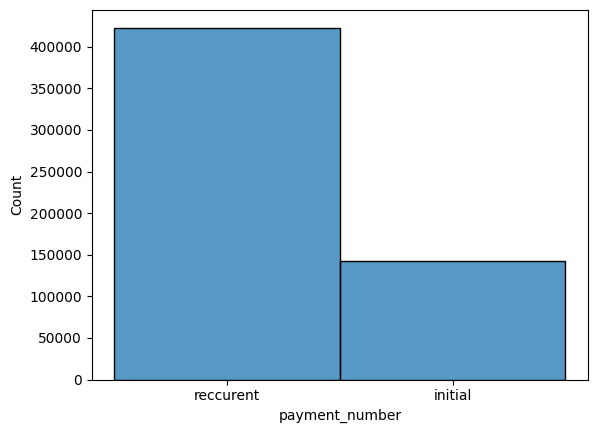

In [15]:
import seaborn as sns
sns.histplot(data['payment_number'], bins=20, kde=False)


<Axes: title={'center': 'Transaction Status'}, xlabel='transaction_status'>

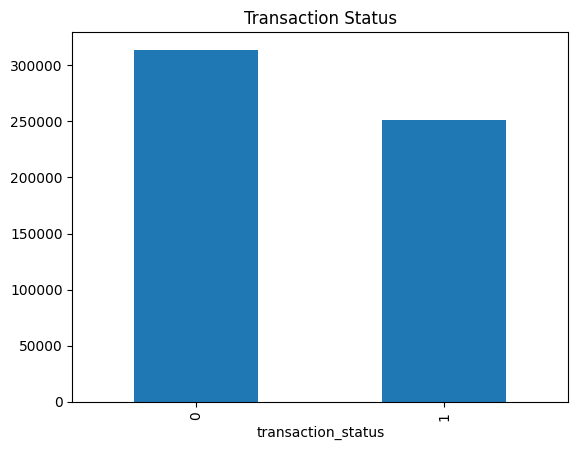

In [50]:
data['transaction_status'].value_counts().plot(kind='bar', title='Transaction Status')


<Axes: xlabel='count', ylabel='card_brand'>

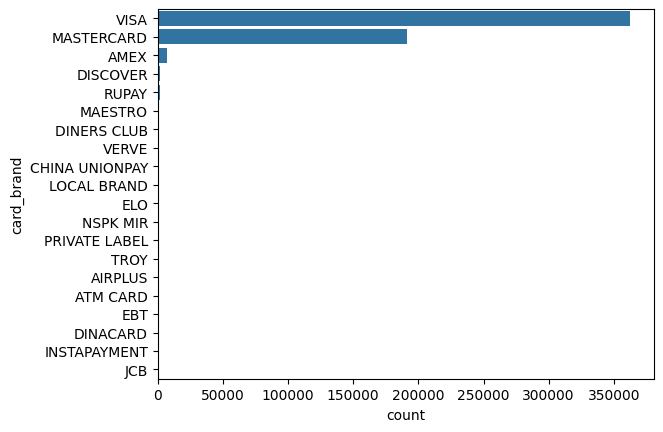

In [51]:
sns.countplot(y='card_brand', data=data, order=data['card_brand'].value_counts().index)


<Axes: xlabel='card_type', ylabel='count'>

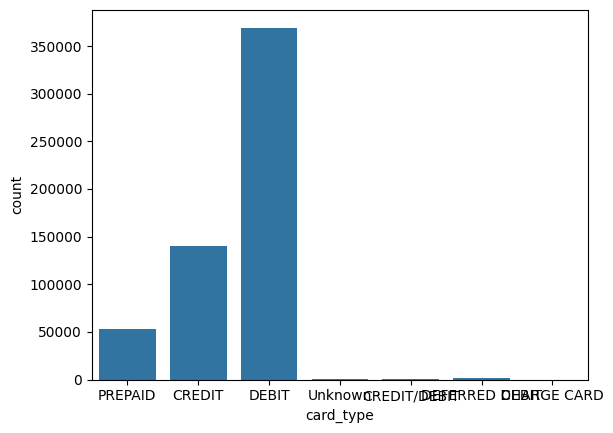

In [52]:
sns.countplot(x='card_type', data=data)


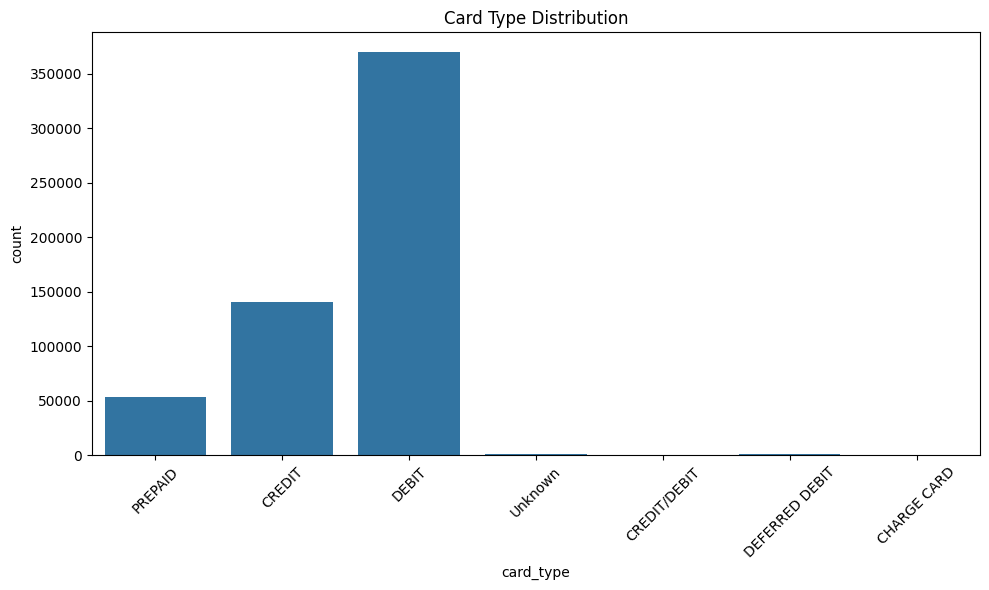

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))  # ширина = 10, висота = 6
sns.countplot(x='card_type', data=data)
plt.title('Card Type Distribution')
plt.xticks(rotation=45)  # за потреби, повертає підписи
plt.tight_layout()
plt.show()


<Axes: title={'center': 'Error Types'}, xlabel='error_type'>

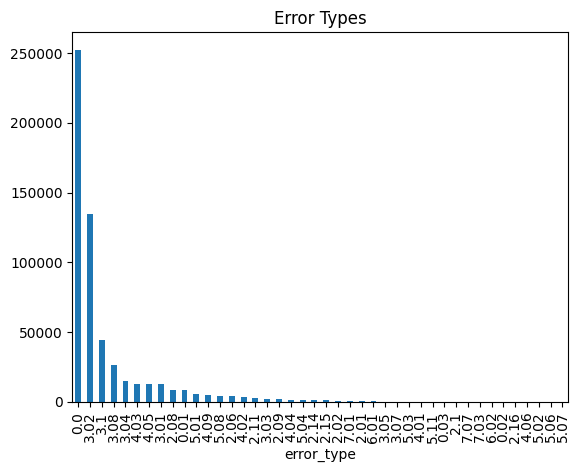

In [54]:
data['error_type'].value_counts().plot(kind='bar', title='Error Types')


<Axes: xlabel='count', ylabel='currency'>

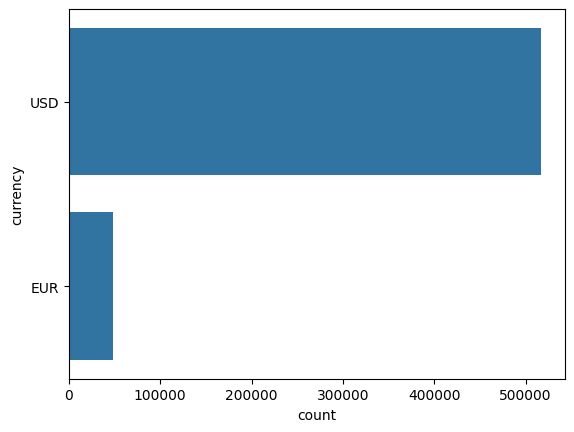

In [55]:
sns.countplot(y='currency', data=data, order=data['currency'].value_counts().index)


<Axes: title={'center': 'Top 10 Card Countries'}, xlabel='card_country'>

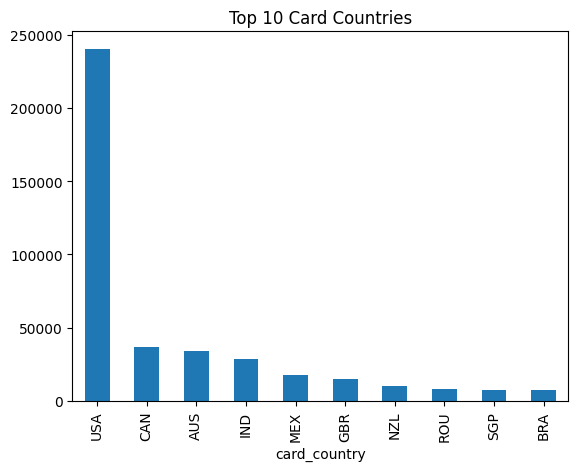

In [56]:
data['card_country'].value_counts().head(10).plot(kind='bar', title='Top 10 Card Countries')


# **2. Exploratory Analysis**

# The first thing we would like to analyze is Daily Transactions: First vs Repeat Purchases
**Initial conclusion**   
The main peaks in sales in 2022 were driven mainly by repeat purchases rather than an influx of new users.

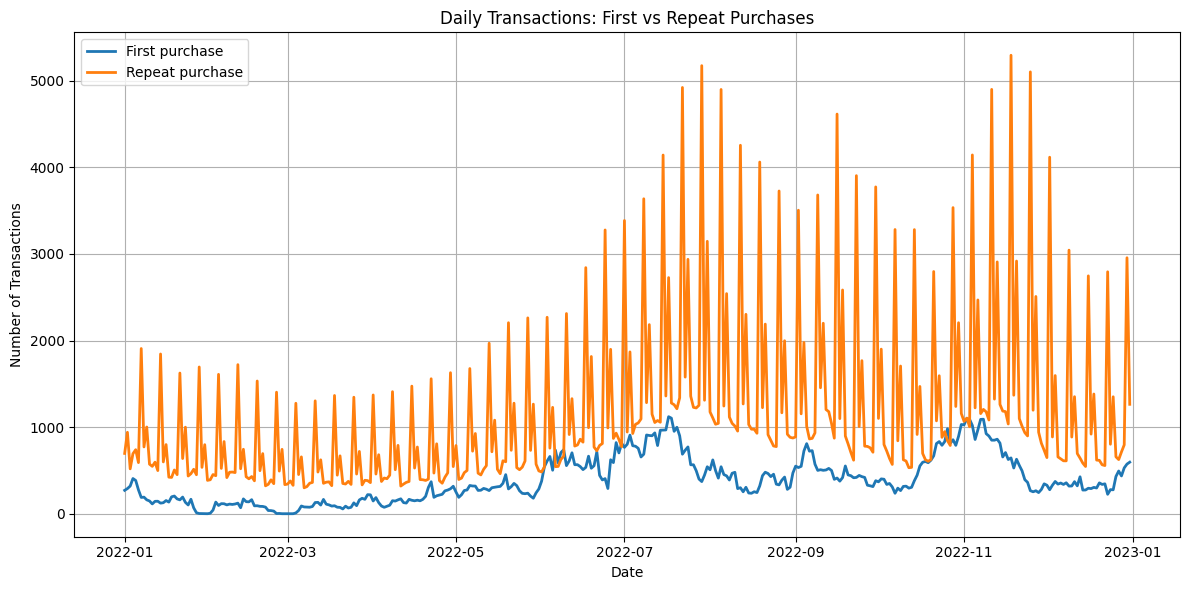

In [16]:
data['date'] = pd.to_datetime(data['event_time']).dt.date

tx_by_type = data.groupby(['date', 'payment_number']).size().unstack().fillna(0)
tx_by_type.columns = ['First purchase', 'Repeat purchase']

plt.figure(figsize=(12, 6))
tx_by_type['First purchase'].plot(label='First purchase', linewidth=2)
tx_by_type['Repeat purchase'].plot(label='Repeat purchase', linewidth=2)
plt.title('Daily Transactions: First vs Repeat Purchases')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
total_users = data['user_id'].nunique()
user_tx_counts = data['user_id'].value_counts()

one_purchase_users = (user_tx_counts == 1).sum()
repeat_purchase_users = (user_tx_counts > 1).sum()
total_users = data['user_id'].nunique()

print(f"Total unique users: {total_users}")
print(f"Users who made only one purchase: {one_purchase_users}")
print(f"Users who made at least two purchases: {repeat_purchase_users}")
print(f"Share of repeat users: {repeat_purchase_users / total_users:.2%}")


Total unique users: 115245
Users who made only one purchase: 40818
Users who made at least two purchases: 74427
Share of repeat users: 64.58%


In [18]:
total_transactions = len(data)
avg_tx_per_user = total_transactions / total_users
print(f"Average number of transactions per user: {avg_tx_per_user:.2f}")


Average number of transactions per user: 4.91


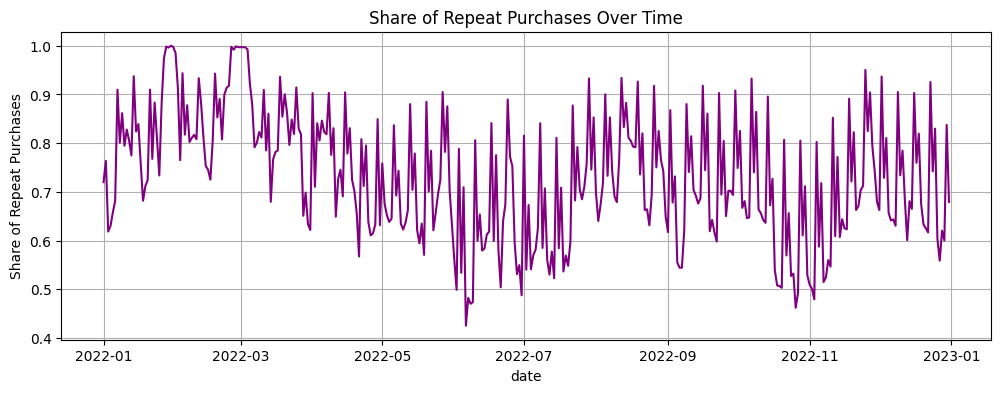

In [19]:
tx_by_type['Repeat Share'] = tx_by_type['Repeat purchase'] / (tx_by_type['First purchase'] + tx_by_type['Repeat purchase'])

tx_by_type['Repeat Share'].plot(figsize=(12, 4), color='purple', title='Share of Repeat Purchases Over Time')
plt.ylabel('Share of Repeat Purchases')
plt.grid(True)
plt.show()


This indicator shows what share of transactions are made by users for the second or more times, i.e. not the first purchase.

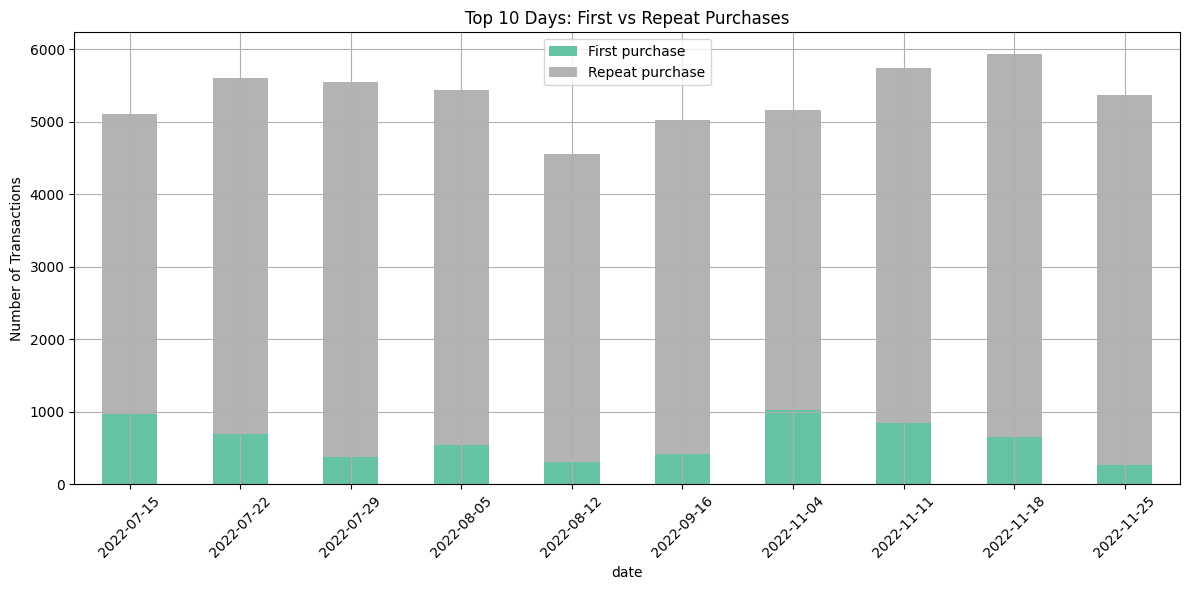

In [20]:
top_days = data['date'].value_counts().sort_values(ascending=False).head(10).index

peak_data = data[data['date'].isin(top_days)]

peak_grouped = peak_data.groupby(['date', 'payment_number']).size().unstack().fillna(0)
peak_grouped.columns = ['First purchase', 'Repeat purchase']
peak_grouped = peak_grouped.sort_index()

peak_grouped.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Set2')
plt.title('Top 10 Days: First vs Repeat Purchases')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


**Key Metrics:**
- **Unique users:** 115,245
- **One-time buyers:** 48,088 (41.7%)
- **Repeat buyers:** 74,437 (64.6%)
- **Avg. transactions per user:** 4.91
- **Daily share of repeat purchases:** 80–90%

**Main Insights:**
- The majority of transactions come from repeat purchases, not first-time buyers.
- Even during peak activity days (e.g., 11.11, 11.18, 07.15), repeat transactions dominate — up to 4–5× more than first-time purchases.
- User loyalty is strong: most users return regularly, indicating product satisfaction.
- However, the volume of new users remains low, suggesting limited acquisition efforts or a narrow target audience.

**Strategic Recommendations:**
- **Scale new user acquisition**   
Boost performance marketing to grow the user base, as current growth is mainly driven by returning users.
- **Reinforce user retention**  
Maintain loyalty through personalized horoscope content, reminders, and incentives for returning users.
- **Leverage seasonal and astrological peaks**   
Launch campaigns 7–10 days ahead of high-interest periods (e.g., full moons, retrogrades) to maximize conversions.
- **Forecast demand using current patterns**   
Build a predictive model based on transaction behavior to support better timing and resource allocation.

**However, it is important to look at other factors and combine this finding with others**

# it is still interesting to study the issue of successful payments, as they are much more valuable for the company

In [21]:
successful_data = data[data['transaction_status'] == 1]

In [22]:
total_users = successful_data['user_id'].nunique()

user_tx_counts = successful_data['user_id'].value_counts()
one_purchase_users = (user_tx_counts == 1).sum()
repeat_purchase_users = (user_tx_counts > 1).sum()

total_transactions = len(successful_data)
avg_tx_per_user = total_transactions / total_users

print(f"Unique users (successful only): {total_users}")
print(f"One-time buyers: {one_purchase_users}")
print(f"Repeat buyers: {repeat_purchase_users}")
print(f"Avg. transactions per user: {avg_tx_per_user:.2f}")


Unique users (successful only): 70181
One-time buyers: 33579
Repeat buyers: 36602
Avg. transactions per user: 3.58


**We calculate all the same metrics, but for successful transactions, as you can see, the results are different**   
The ratio between one time and repeat has become almost the same

/var/folders/z6/xyjmcw990rjdwjfc_phrk3400000gn/T/ipykernel_67140/1364769989.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  successful_data['event_time'] = pd.to_datetime(successful_data['event_time'])


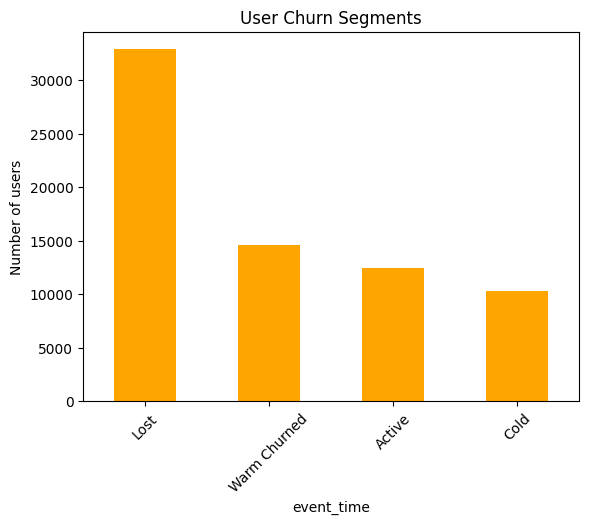

In [23]:
successful_data['event_time'] = pd.to_datetime(successful_data['event_time'])

max_date = successful_data['event_time'].max()

last_tx = successful_data.groupby('user_id')['event_time'].max()

days_since_last_tx = (max_date - last_tx).dt.days


def churn_segment(days):
    if days <= 30:
        return 'Active'
    elif days <= 60:
        return 'Cold'
    elif days <= 120:
        return 'Warm Churned'
    elif days <= 365:
        return 'Lost'

user_segments = days_since_last_tx.apply(churn_segment)
user_segments.value_counts().plot(kind='bar', color='orange')
plt.title('User Churn Segments')
plt.ylabel('Number of users')
plt.xticks(rotation=45)
plt.show()


In [24]:
successful_data = data[data['transaction_status'] == 1]
successful_data['event_time'] = pd.to_datetime(successful_data['event_time'])

max_date = successful_data['event_time'].max()

last_tx = successful_data.groupby('user_id')['event_time'].max()

days_since_last = (max_date - last_tx).dt.days

churned = (days_since_last > 30).sum()
active = (days_since_last <= 30).sum()

print(f"Active (≤30 days): {active}")
print(f"Churned (>30 days): {churned}")
print(f"Churn rate: {churned / (active + churned):.2%}")


/var/folders/z6/xyjmcw990rjdwjfc_phrk3400000gn/T/ipykernel_67140/2247821634.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  successful_data['event_time'] = pd.to_datetime(successful_data['event_time'])


Active (≤30 days): 12468
Churned (>30 days): 57713
Churn rate: 82.23%


**This graph and results clearly indicate the types of our clients and confirm the need to work with the uninterested.**

In [25]:
tx_count = successful_data['user_id'].value_counts()

one_time_ids = tx_count[tx_count == 1].index
multi_time_ids = tx_count[tx_count > 1].index

one_time_df = successful_data[successful_data['user_id'].isin(one_time_ids)]
multi_time_df = successful_data[successful_data['user_id'].isin(multi_time_ids)]

print("Card Country Comparison:")
print(pd.concat([
    one_time_df['card_country'].value_counts(normalize=True).rename("1-time"),
    multi_time_df['card_country'].value_counts(normalize=True).rename("2+ times")
], axis=1).fillna(0))

print("\nCard Brand Comparison:")
print(pd.concat([
    one_time_df['card_brand'].value_counts(normalize=True).rename("1-time"),
    multi_time_df['card_brand'].value_counts(normalize=True).rename("2+ times")
], axis=1).fillna(0))


Card Country Comparison:
                1-time  2+ times
card_country                    
USA           0.421633  0.403371
CAN           0.056702  0.076538
IND           0.048751  0.032693
AUS           0.038655  0.077571
MEX           0.029751  0.019466
...                ...       ...
NCL           0.000000  0.000014
LBY           0.000000  0.000014
AFG           0.000000  0.000009
SMR           0.000000  0.000009
TCD           0.000000  0.000009

[185 rows x 2 columns]

Card Brand Comparison:
               1-time  2+ times
card_brand                     
VISA         0.646654  0.643183
MASTERCARD   0.329700  0.344848
AMEX         0.019625  0.009485
DISCOVER     0.002978  0.002351
DINERS CLUB  0.000536  0.000078
MAESTRO      0.000506  0.000055


**This frame compares user profiles based on how many successful transactions they have made**      
This is the distribution of all transactions by country and card brand, normalized to 1.0, i.e:
- The sum of all values in each column ≈ 1.0 (or 100%).
- For example, in the 1-time column for card_country, a value of 0.421603 for USA means that 42.16% of all one-time successful transactions were from cards issued in the United States.

In [26]:
fail_users = data[data['transaction_status'] == 0]['user_id'].value_counts()

only_fail_users = set(fail_users.index) - set(successful_data['user_id'].unique())

print(f"Users with at least 1 failed tx: {len(fail_users)}")
print(f"Users who never had a successful tx: {len(only_fail_users)}")


Users with at least 1 failed tx: 90084
Users who never had a successful tx: 45064


**The results are shocking and force us to investigate and look for ways to improve this)**

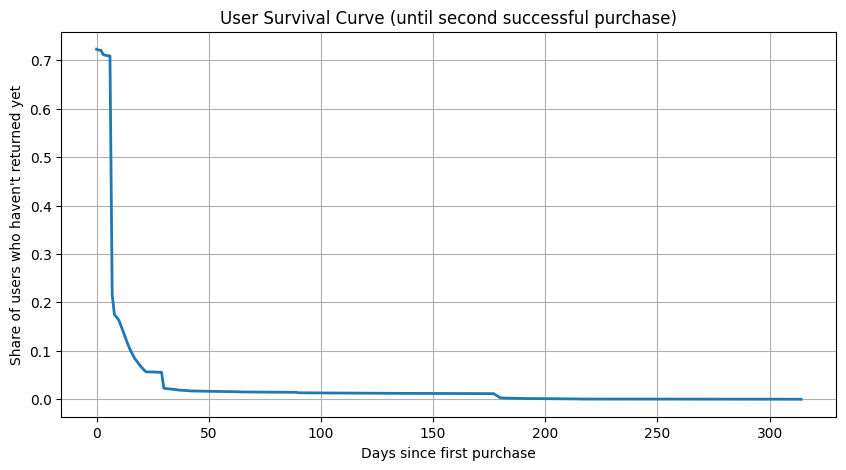

In [27]:
data['event_time'] = pd.to_datetime(data['event_time'])

successful_data = data[data['transaction_status'] == 1]


successful_data_sorted = successful_data.sort_values(by=['user_id', 'event_time'])

successful_data_sorted['tx_rank'] = successful_data_sorted.groupby('user_id').cumcount() + 1

first_tx = successful_data_sorted[successful_data_sorted['tx_rank'] == 1]
second_tx = successful_data_sorted[successful_data_sorted['tx_rank'] == 2]

merged = pd.merge(
    first_tx[['user_id', 'event_time']],
    second_tx[['user_id', 'event_time']],
    on='user_id',
    suffixes=('_first', '_second')
)

merged['days_between'] = (merged['event_time_second'] - merged['event_time_first']).dt.days

retention_curve = merged['days_between'].value_counts().sort_index().cumsum()
retention_curve_pct = retention_curve / retention_curve.max()

plt.figure(figsize=(10, 5))
plt.plot(retention_curve_pct.index, 1 - retention_curve_pct.values, linewidth=2)
plt.title("User Survival Curve (until second successful purchase)")
plt.xlabel("Days since first purchase")
plt.ylabel("Share of users who haven't returned yet")
plt.grid(True)
plt.show()


**Key Metrics:**
- **Unique users(successsful):**  70,181
- **One-time buyers:** 33,560 (47.8%)
- **Repeat buyers:** 36,621 (52.2%)
- **Avg. transactions per user:** 3.60
- **Daily share of repeat purchases:** 82.2%

**Main Insights:**
- **High churn rate:**
82.2% of users haven’t returned within the last 30 days — This is a signal that users have not made a new transaction for more than 30 days. But this does not necessarily mean that they are lost - it all depends on the product model (one-time purchase, subscription, gift item, etc.). A more detailed analysis will follow
- **Significant share of one-time buyers:**
47.8% of users make only one successful purchase and never return — this highlights the need for an activation strategy after the first transaction.
- **Profile: One-time vs Loyal users:**
    - Countries with higher share of one-time buyers: USA, India, Mexico
    - Loyal users are more common from: Canada, Australia
    - MASTERCARD appears slightly more common among repeat buyers.
- **Failed transactions = lost opportunity:**
90,084 users experienced at least one failed transaction.
Of them, 45,064 never made a successful purchase — these are potential customers that were lost before conversion

**The most common combination: VISA + USA + Summer + 3 transactions**

**Strategic Recommendations:**
- **Recover “almost-customers”:**
    - Segment the 45k users who experienced a failed transaction but never completed a successful one. Trigger follow-ups, reminders, or special offers to bring them back.
- **Improve first-time experience:**
    - For users who made their first purchase, launch a Welcome Flow with 2–3 reminders or incentives within the first 7 days to encourage a second transaction.
- **Analyze card and country-level friction:**
    - Investigate if there are certain cards (e.g., AMEX, VISA) or regions with higher failure rates - this could indicate technical or user interface issues. - More research on this to come

# Investigating of the impact of the time of day on the number of transactions

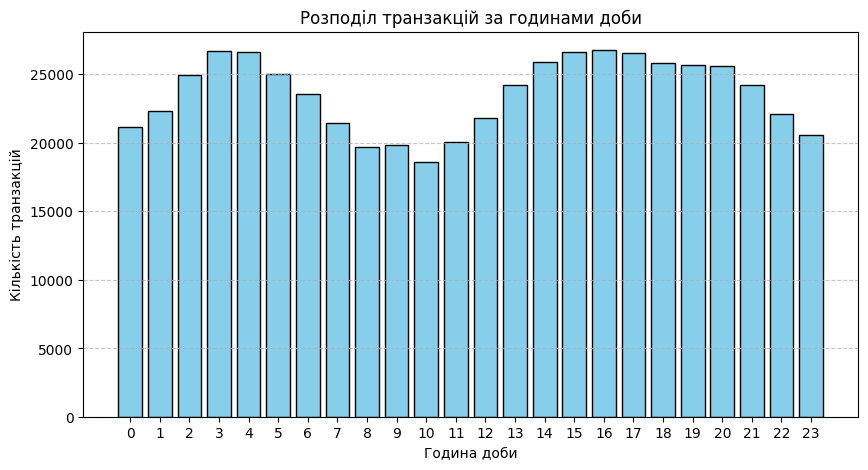

In [28]:
data["event_time"] = pd.to_datetime(data["event_time"], errors="coerce")
data = data.dropna(subset=["event_time"])

data["hour"] = data["event_time"].dt.hour
hourly_counts = data["hour"].value_counts().sort_index()

plt.figure(figsize=(10, 5))
plt.bar(hourly_counts.index, hourly_counts.values, color="skyblue", edgecolor="black")
plt.xlabel("Година доби")
plt.ylabel("Кількість транзакцій")
plt.title("Розподіл транзакцій за годинами доби")
plt.xticks(range(24))
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

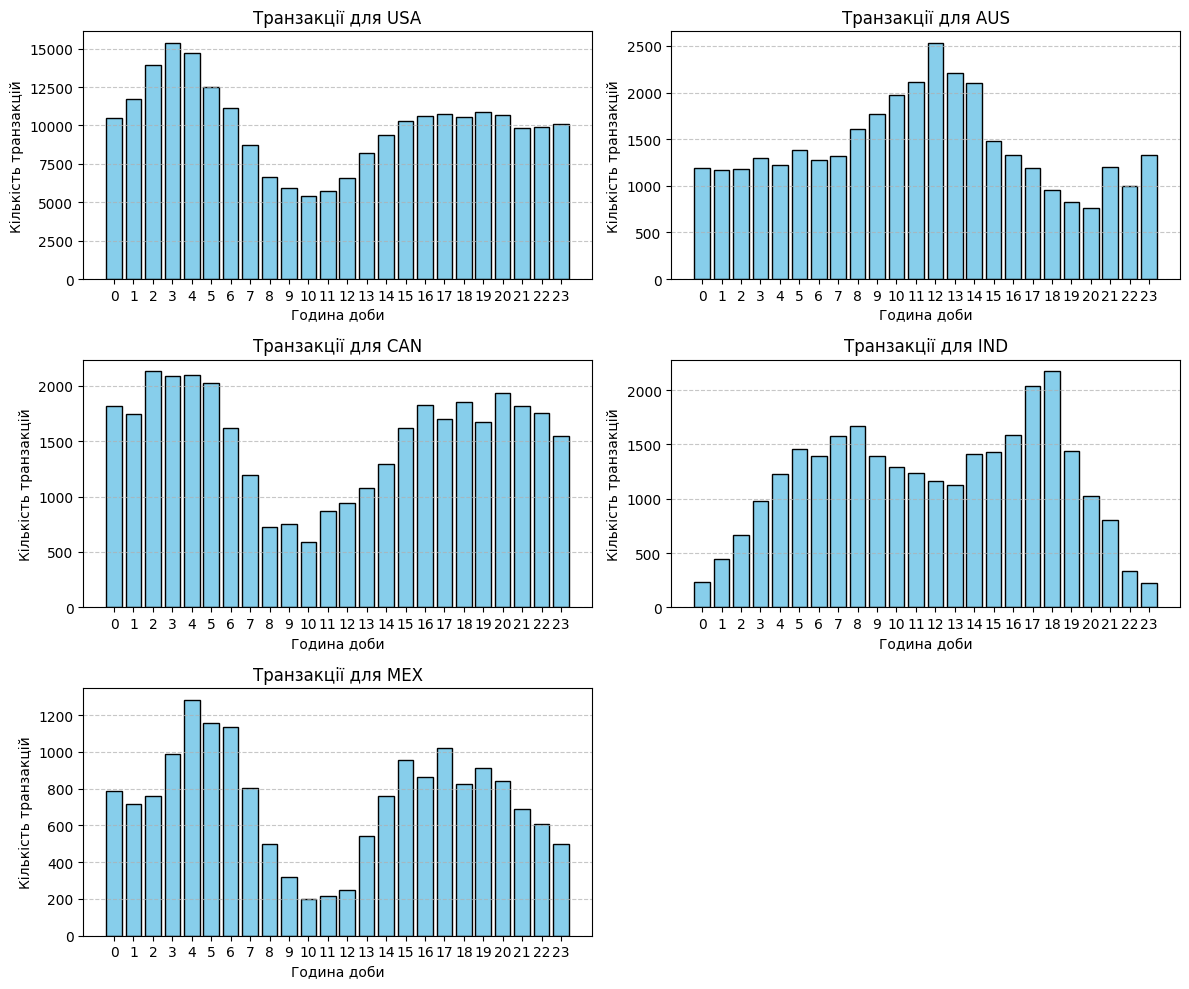

In [29]:
data["hour"] = data["event_time"].dt.hour

selected_countries = ["USA", "AUS", "CAN", "IND", "MEX"]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
axes = axes.flatten()

for i, country in enumerate(selected_countries):
    subset = data[data["card_country"] == country]
    hourly_counts = subset["hour"].value_counts().sort_index()
    
    axes[i].bar(hourly_counts.index, hourly_counts.values, color="skyblue", edgecolor="black")
    axes[i].set_title(f"Транзакції для {country}")
    axes[i].set_xlabel("Година доби")
    axes[i].set_ylabel("Кількість транзакцій")
    axes[i].set_xticks(range(24)) 
    axes[i].grid(axis="y", linestyle="--", alpha=0.7)

if len(selected_countries) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

**The largest number of transactions in the USA (which is our main market) occurs at 03/04 am UTC, i.e. approximately 21/22/23.00 in the United States of America (time varies by state)**.

# Selecting the target currency

In [30]:
data_eur = data[data["currency"] == "EUR"]
data_usd = data[data["currency"] == "USD"]
count_eur = data_eur.shape[0]
count_usd = data_usd.shape[0]

print(f"Загалом транзакцій в EUR: {count_eur}")
print(f"Загалом транзакцій в USD: {count_usd}")


Загалом транзакцій в EUR: 48125
Загалом транзакцій в USD: 517190


**Since the number of USD transactions is more than 10 times higher than the number of EUR transactions at this stage, we will consider only them**.

# Investigating most common prices

In [31]:
data_usd = data[data["currency"] == "USD"]
if 'price' in data_usd.columns:
    price_counts = data_usd['price'].value_counts()
    print(price_counts)

price
36.0     185298
5.0      105404
21.0      69906
9.0       38588
12.0      16339
38.0      15605
28.0      13591
20.0      11532
73.0      10359
24.0       9918
27.0       9133
29.0       7116
4.0        4894
54.0       3964
90.0       2343
33.0       2084
19.0       1896
7.0        1568
55.0       1330
10.0       1290
6.0        1231
16.0       1131
64.0       1103
53.0        526
32.0        202
41.0        170
23.0        147
14.0        138
26.0        104
18.0         91
8.0          54
66.0         40
42.0         21
48.0         17
17.0         15
35.0         13
22.0         10
85.0          5
107.0         5
46.0          5
106.0         4
Name: count, dtype: int64


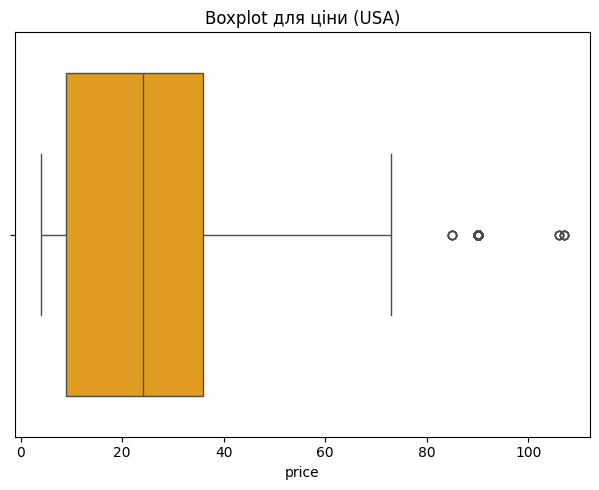

In [32]:
data_usd = data[data["currency"] == "USD"]
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
sns.boxplot(x=data_usd['price'], color='orange')
plt.title('Boxplot для ціни (USA)')

plt.tight_layout()
plt.show()

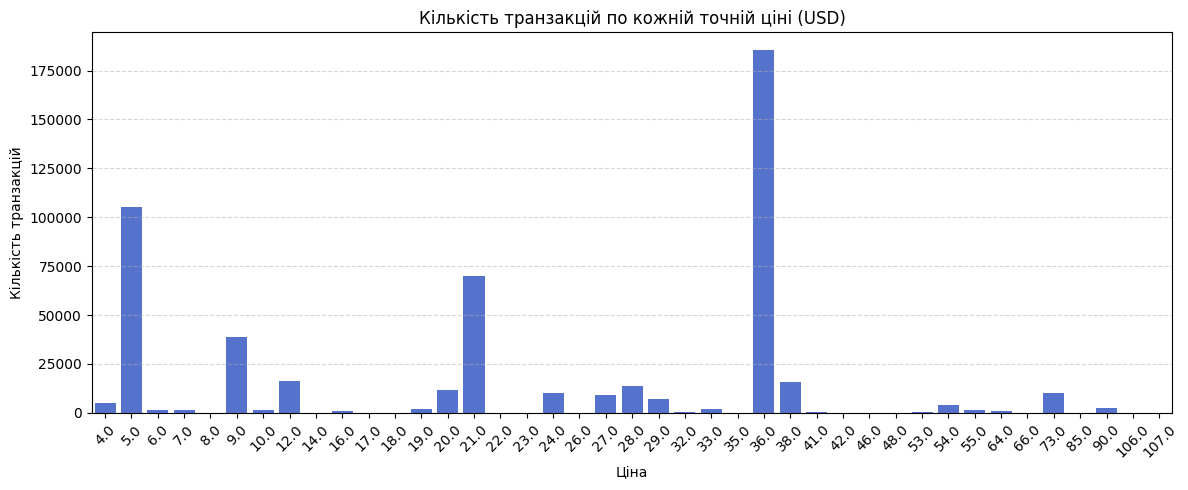

In [33]:
price_counts = data_usd["price"].value_counts().sort_index()
plt.figure(figsize=(12, 5))
sns.barplot(x=price_counts.index, y=price_counts.values, color="royalblue")
plt.title("Кількість транзакцій по кожній точній ціні (USD)")
plt.xlabel("Ціна")
plt.ylabel("Кількість транзакцій")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [34]:
data_usd = data[data["currency"] == "USD"]
purchase_counts = data_usd.groupby(['price', 'payment_number']).size().unstack(fill_value=0)
purchase_counts.rename(columns={'reccurent': 'recurrent'}, inplace=True)
purchase_counts['recurrent_ratio'] = purchase_counts.get('recurrent', 0) / (
    purchase_counts.get('initial', 0) + purchase_counts.get('recurrent', 0)
)
purchase_counts['total'] = purchase_counts.get('initial', 0) + purchase_counts.get('recurrent', 0)
purchase_counts = purchase_counts.sort_values('total', ascending=False)
print(purchase_counts)


payment_number  initial  recurrent  recurrent_ratio   total
price                                                      
36.0                 19     185279         0.999897  185298
5.0              102767       2637         0.025018  105404
21.0                681      69225         0.990258   69906
9.0                   0      38588         1.000000   38588
12.0               8878       7461         0.456637   16339
38.0                  0      15605         1.000000   15605
28.0                  0      13591         1.000000   13591
20.0                  0      11532         1.000000   11532
73.0                 28      10331         0.997297   10359
24.0                  0       9918         1.000000    9918
27.0               9084         49         0.005365    9133
29.0                  0       7116         1.000000    7116
4.0                4631        263         0.053739    4894
54.0                 73       3891         0.981584    3964
90.0                  0       2343      

Although $36 is the most common price point with over 185,000 transactions, only 19 of them are labeled as initial.   
Nearly all are marked as recurrent, resulting in an exceptionally high conversion ratio (99.99%). This suggests that $36 is likely the standard recurring subscription amount, not used for trial or first-time purchases.   
Most users probably start with a lower initial payment (e.g., $5 or $12), and transition to $36 in their billing cycle.   

In [35]:
data_usd = data[data["currency"] == "USD"]
initial_purchases = data_usd[data_usd['payment_number'] == 'initial'][['user_id', 'price']]
recurrent_users = set(data_usd[data_usd['payment_number'] == 'reccurent']['user_id'])
initial_purchases['had_recurrent'] = initial_purchases['user_id'].isin(recurrent_users)
recurrent_analysis = initial_purchases.groupby('price')['had_recurrent'].mean() * 100 
print(recurrent_analysis.round(2).astype(str) + '%')

price
4.0     41.72%
5.0     40.52%
12.0    52.13%
19.0    52.43%
21.0    23.94%
23.0    53.06%
27.0     47.7%
32.0    60.89%
36.0    26.32%
54.0    32.88%
73.0    10.71%
Name: had_recurrent, dtype: object


### This analysis shows the percentage of users who made a recurrent payment after their initial transaction at each price point. Key findings include:

* The highest conversion rate was at $32, where 60.89% of users continued with a recurrent payment.
* Other strong-performing price points were $23 (53.06%), $19 (52.43%), and $12 (52.13%).
* The popular entry-level price of $5 showed a moderate conversion rate of 40.52%.
* The standard price of $36 had a relatively low conversion rate of 26.32%, despite being the most common overall.
* Higher-tier pricing like $73 showed minimal user retention (10.71%).
* These insights suggest that lower to mid-tier pricing may be more effective at converting users to recurring payments, and further analysis could help optimize pricing strategy.

Number of users who paid $36 in USD and had both types of transactions (initial + recurring): 38505”   
This means that 38,505 unique users who paid $36 went through the full payment cycle:   

First - initial   
Then - reccurent (i.e. repeated payment)   

**This analysis shows the percentage of users who made a recurrent payment after their initial purchase at each price point. For example, 60.89% of users who paid $32 eventually made another payment, while only 26.32% of those who paid $36 did the same. This suggests that some lower price points may lead to better user retention than higher or more popular ones like $36.**

In [36]:
data_usd = data[data["currency"] == "USD"].copy()
data_usd["event_time"] = pd.to_datetime(data_usd["event_time"])
data_usd["payment_number"] = data_usd["payment_number"].replace("reccurent", "recurrent")
initial_df = data_usd[data_usd["payment_number"] == "initial"]
recurrent_df = data_usd[data_usd["payment_number"] == "recurrent"]
initial_with_recurrent = []
recurrent_times = recurrent_df.groupby("user_id")["event_time"].min()

for idx, row in initial_df.iterrows():
    user = row["user_id"]
    init_time = row["event_time"]
    price = row["price"]
    if user in recurrent_times and recurrent_times[user] > init_time:
        initial_with_recurrent.append((user, price))
result_df = pd.DataFrame(initial_with_recurrent, columns=["user_id", "initial_price"])
summary = result_df.groupby("initial_price")["user_id"].nunique().sort_values(ascending=False)
print(summary)


initial_price
5.0     35190
12.0     4121
27.0     3852
4.0      1210
19.0      885
21.0      127
32.0      107
23.0       74
54.0       21
36.0        5
73.0        2
Name: user_id, dtype: int64


This analysis identifies how many unique users transitioned from an initial to a recurrent payment, grouped by the price of their initial transaction.   

The highest number of users who converted to recurrent payments started with $5 (35,190 users), followed by $12 (4,121) and $27 (3,852).   
Other price points with notable conversion counts include $4 (1,210 users) and $19 (885 users).   
Interestingly, although $36 is the most common overall transaction amount, only 5 users had $36 as their initial payment before a recurrent one — confirming that $36 is typically not used as a first-time purchase price.   
Lower and mid-range price points appear to be more effective entry levels for converting users into subscribers.   
These insights can inform pricing strategies and onboarding flows to optimize user retention   

**Important results:**
* $5 – the most common initial transaction
This suggests that new users are willing to pay $5 to try the app. However, the conversion rate to recurrent payments is quite low (~2.5%), indicating that while this price is effective for acquisition, it may need additional incentives or nurturing to improve retention.
* $36 – the most common recurrent transaction
Almost all $36 transactions are recurrent, meaning users who enjoy the app and decide to stay long-term are willing to pay this price. It's likely the standard subscription rate following the initial trial period.

* $27 and $19 – high initial volume but low conversion
Many users start with these prices, but very few continue. This indicates potential pricing misalignment or unmet expectations at these tiers.

Despite the app charging in USD, users from certain European countries demonstrate stronger loyalty and engagement, which could inform localized marketing or retention strategies.   
Average delay between initial and recurrent payment is short   
Most users who convert do so quickly  which highlights the importance of early engagement and onboarding flows.   
Users with multiple initial payments but no recurrent  
A segment of users makes several initial transactions without ever subscribing. Understanding their behavior and friction points may help unlock additional revenue through targeted loyalty or win-back campaigns.   

# Next, we focus on the study of banks. Therefore, we decided to display the top 10 countries by the number of all transactions made. 
# This research is in a separate file, as it is very voluminous

# Now let's focus on Europe and see if this region is important for us at all

In [ ]:
successful_data.loc[:, 'card_country'] = successful_data['card_country'].str.strip().str.upper()

europe_countries = [
    'FRA', 'DEU', 'ESP', 'ITA', 'NLD', 'BEL', 'SWE', 'NOR', 'CHE', 'AUT', 'POL',
    'ROU', 'GRC', 'CZE', 'UKR', 'PRT', 'FIN', 'GBR', 'EST', 'MDA', 'LVA', 'IRL',
    'SVK', 'SRB', 'LTU', 'ALB', 'BIH', 'HRV', 'ISL', 'BGR', 'HUN', 'DNK', 'LUX',
    'CYP', 'MLT', 'SVN', 'AND', 'XKX', 'SMR'
]

america_countries = [
    'USA'
]

europe_tx = successful_data[successful_data['card_country'].isin(europe_countries)]
america_tx = successful_data[successful_data['card_country'].isin(america_countries)]

europe_user_spend = europe_tx.groupby('user_id')['price'].sum()
america_user_spend = america_tx.groupby('user_id')['price'].sum()

europe_avg_spend_per_user = europe_user_spend.mean()
america_avg_spend_per_user = america_user_spend.mean()

print(f"Average revenue per user (Europe): ${europe_avg_spend_per_user:.2f}")
print(f"Average revenue per user (America): ${america_avg_spend_per_user:.2f}")


Average revenue per user (Europe): $81.79
Average revenue per user (America): $75.57


**European users generate more revenue per person than American users.**   
The difference of ~8.2% is not critical, but it is significant for a large-scale business.   
**Regional focus matters:** even if the number of US users is higher, it may be more profitable to attract Europeans in certain campaigns (for example, for premium products).

In [ ]:
europe_data = data[data['card_country'].isin(europe_countries)]

bank_stats = europe_data.groupby(['bank_name', 'transaction_status'])['user_id'].count().unstack(fill_value=0)
bank_stats.columns = ['Failed', 'Successful'] if 0 in bank_stats.columns else bank_stats.columns
bank_stats['Total'] = bank_stats.sum(axis=1)
bank_stats['Success Rate'] = bank_stats['Successful'] / bank_stats['Total']

top_banks = bank_stats.sort_values('Total', ascending=False).head(10)


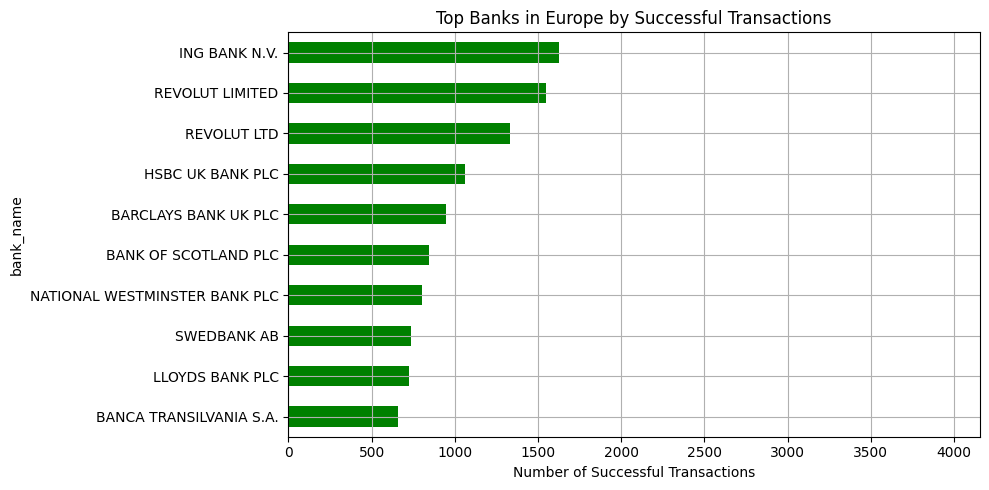

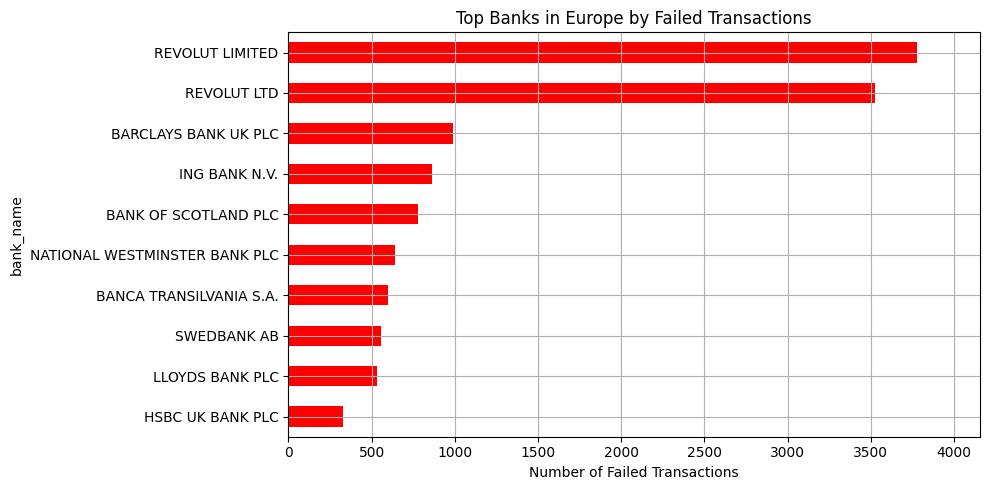

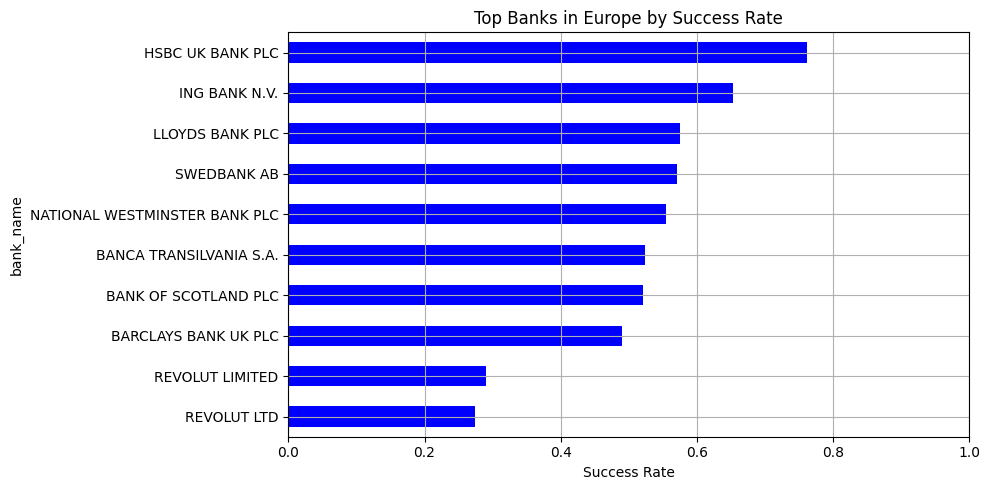

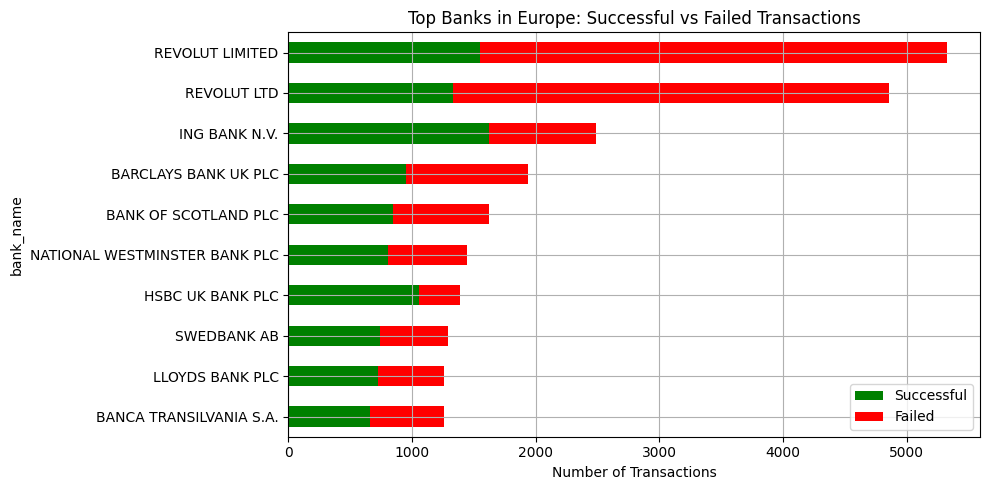

In [ ]:
bank_stats = europe_data.groupby(['bank_name', 'transaction_status'])['user_id'].count().unstack(fill_value=0)
bank_stats.columns = ['Failed', 'Successful'] if 0 in bank_stats.columns else bank_stats.columns
bank_stats['Total'] = bank_stats.sum(axis=1)
bank_stats['Success Rate'] = bank_stats['Successful'] / bank_stats['Total']

top_banks = bank_stats.sort_values('Total', ascending=False).head(10)

xmax = max(top_banks['Successful'].max(), top_banks['Failed'].max()) * 1.1

plt.figure(figsize=(10, 5))
top_banks['Successful'].sort_values().plot(kind='barh', color='green')
plt.title('Top Banks in Europe by Successful Transactions')
plt.xlabel('Number of Successful Transactions')
plt.xlim(0, xmax)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
top_banks['Failed'].sort_values().plot(kind='barh', color='red')
plt.title('Top Banks in Europe by Failed Transactions')
plt.xlabel('Number of Failed Transactions')
plt.xlim(0, xmax)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
top_banks['Success Rate'].sort_values().plot(kind='barh', color='blue')
plt.title('Top Banks in Europe by Success Rate')
plt.xlabel('Success Rate')
plt.xlim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

top_banks_sorted = top_banks.sort_values('Total')

top_banks_sorted[['Successful', 'Failed']].plot(
    kind='barh',
    stacked=True,
    figsize=(10, 5),
    color=['green', 'red']
)
plt.title('Top Banks in Europe: Successful vs Failed Transactions')
plt.xlabel('Number of Transactions')
plt.grid(True)
plt.tight_layout()
plt.show()



**The plots show different ratios and ratings of banks**

In [ ]:
europe_success = (europe_data['transaction_status'] == 1).sum()
europe_fail = (europe_data['transaction_status'] == 0).sum()

europe_success_rate = europe_success / (europe_success + europe_fail)

print(f"Success Rate in Europe: {europe_success_rate:.2%}")

Success Rate in Europe: 52.58%


In [ ]:
usa_data = data[data['card_country'] == 'USA']

usa_success = (usa_data['transaction_status'] == 1).sum()
usa_fail = (usa_data['transaction_status'] == 0).sum()

usa_success_rate = usa_success / (usa_success + usa_fail)

print(f"Success Rate in USA: {usa_success_rate:.2%}")

Success Rate in USA: 42.47%


**Having calculated the success rate, the importance of Europe in our transaction market is further enhanced, because the significance is critical**

**European banks demonstrate a higher level of transaction reliability:**   
- Average Success Rate for top banks: ~60-70%.
- The most successful banks: HSBC UK BANK PLC, ING BANK N.V., LLOYDS BANK
- Compared to the United States, European banks more often allow payments to go through, and there are fewer cases of blocking/rejections (for example, through prepaid or debit cards).

**As the average transaction price differs between Europe and America**   
**Probably a higher proportion of successful transactions → more opportunities for repeat purchases and fewer losses at the payment gateway stage.**

# Seasonality 
We decided to look at the seasonality of sales and see if there might be a significant situation here that would give us insights.

To do this, we plotted graphs of the time period and the number of transactions during that period.

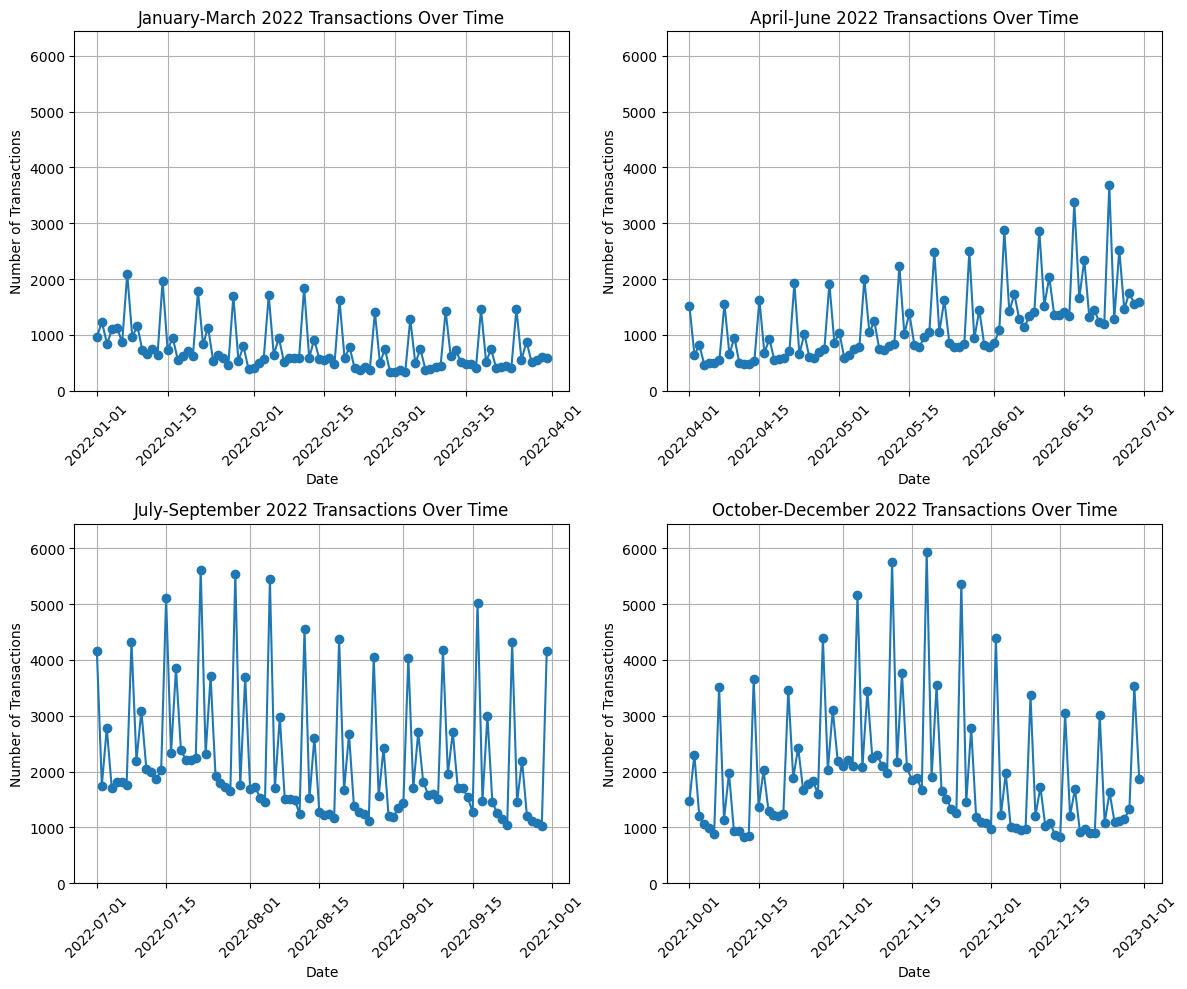

In [ ]:
data['event_time'] = pd.to_datetime(data['event_time'])

data['month'] = data['event_time'].dt.month
data['date'] = data['event_time'].dt.date

def get_season(row):
    month = row['month']
    year = row['event_time'].year
    if month in [1, 2, 3]:
        return f'January-March {year}'
    elif month in [4, 5, 6]:
        return f'April-June {year}'
    elif month in [7, 8, 9]:
        return f'July-September {year}'
    else:
        return f'October-December {year}'


data['season'] = data.apply(get_season, axis=1)

seasons_to_plot = ['January-March 2022', 'April-June 2022', 'July-September 2022', 'October-December 2022']

plt.figure(figsize=(12, 10))


global_max = data.groupby('date').size().max()

for i, season in enumerate(seasons_to_plot):
    plt.subplot(2, 2, i + 1)
    
    season_df = data[data['season'] == season]
    daily_counts = season_df.groupby('date').size()
    
    plt.plot(daily_counts.index, daily_counts.values, marker='o', linewidth=1.5)
    plt.title(f'{season} Transactions Over Time')
    plt.xlabel('Date')
    plt.ylabel('Number of Transactions')
    plt.xticks(rotation=45)
    plt.ylim(0, global_max + 500)
    plt.grid(True)

plt.tight_layout()
plt.show()

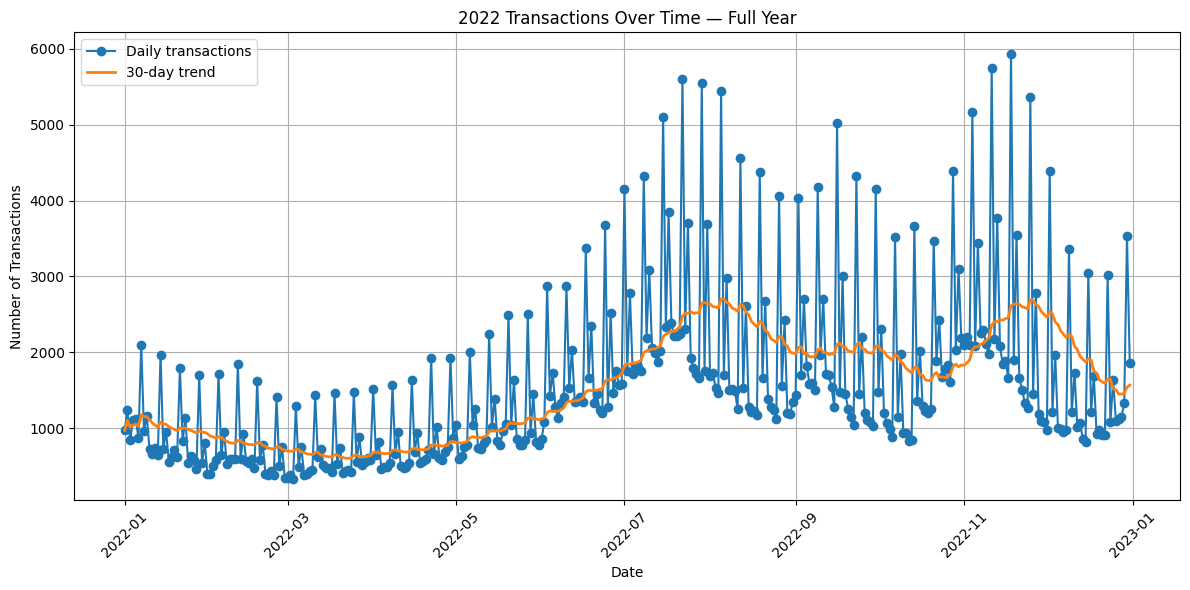

In [ ]:
overall_daily = data.groupby('date').size().sort_index()

trend = overall_daily.rolling(window=30, min_periods=1).mean()

plt.figure(figsize=(12, 6))
plt.plot(overall_daily.index, overall_daily.values, marker='o', linewidth=1.5, label='Daily transactions')
plt.plot(trend.index, trend.values, linewidth=2, label='30‑day trend')
plt.title('2022 Transactions Over Time — Full Year')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

The graphs show clear seasonal trends:

- January–March: low transaction levels

- April–June: gradual increase in activity

- July–September: peak season

- October–December: decline after summer with a small autumn rise in November, then a decline in December.

Based on these results, we put forward the theory that the app was launched in November - December 2021, so we see an increase in the number of transactions at the end of 2022, due to the fact that users at the beginning of the product's existence took out an annual subscription and it was renewed after a year.

The theory was not confirmed, because the product launch was in 2020. Therefore, we decided to further investigate recurring and non-recurring payments separately to see the situation better. Since the general analysis provides little information.


Not USA, Not Europe
Now let's focus on countries outside America and the USA


In [ ]:
unique_countries = data["card_country"].dropna().unique()

In [ ]:
europe_countries = [
    'FRA', 'DEU', 'ESP', 'ITA', 'NLD', 'BEL', 'SWE', 'NOR', 'CHE', 'AUT', 'POL',
    'ROU', 'GRC', 'CZE', 'UKR', 'PRT', 'FIN', 'GBR', 'EST', 'MDA', 'LVA', 'IRL',
    'SVK', 'SRB', 'LTU', 'ALB', 'BIH', 'HRV', 'ISL', 'BGR', 'HUN', 'DNK', 'LUX',
    'CYP', 'MLT', 'SVN', 'AND', 'XKX', 'SMR', 'USA'
]

data = data[~data['card_country'].isin(europe_countries)]
data

unique_countries = data["card_country"].dropna().unique()


In [ ]:
total_tran = len(data)
success = (data["transaction_status"] == 1).sum()
conversion_rate = success / total_tran


print(f"Success Rate in other countries(not Europe and not USA): {conversion_rate:.2%}")

Success Rate in other countries(not Europe and not USA): 43.78%


Other countries are not as significant, because of low Success Rate. 

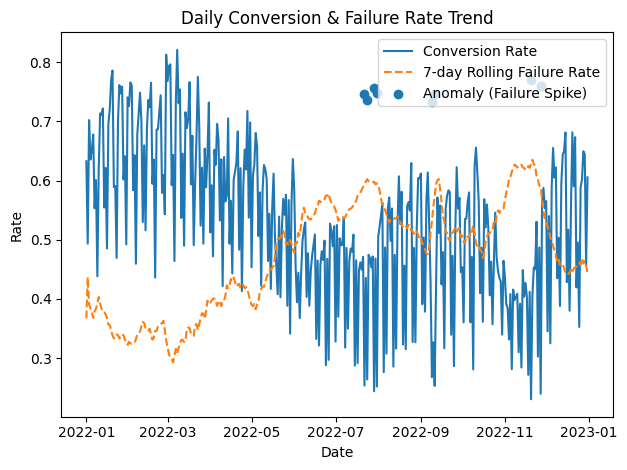

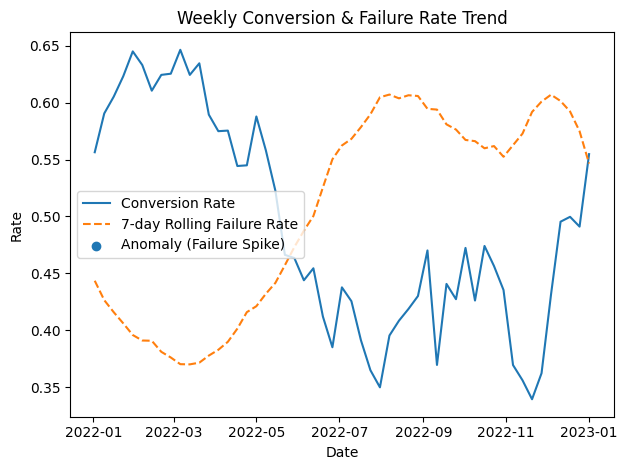

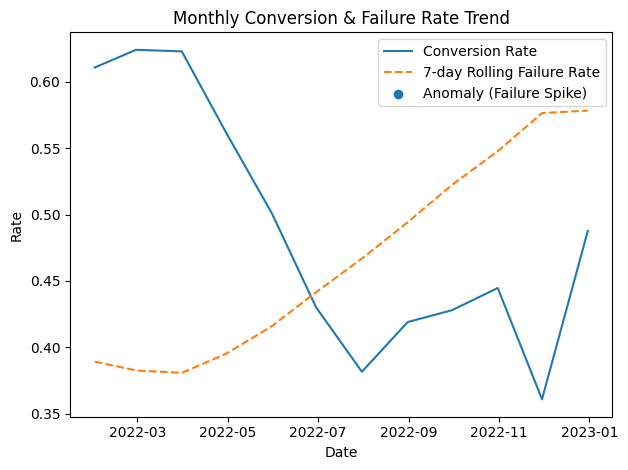

In [ ]:
data = data.reset_index() 
data['event_time'] = pd.to_datetime(data['event_time'])
data.set_index('event_time', inplace=True)


def make_trend(data, freq):
    grouped = data.resample(freq).agg(
        total_tran=('order_id', 'count'),
        success=('transaction_status', lambda x: (x == 1).sum())
    )
    grouped['conversion_rate'] = grouped['success'] / grouped['total_tran']
    grouped['failure_rate'] = 1 - grouped['conversion_rate']
    grouped['rolling_failure'] = grouped['failure_rate'].rolling(window=7, min_periods=1).mean()
    grouped['z_score_fail'] = (grouped['failure_rate'] - grouped['failure_rate'].mean()) / grouped['failure_rate'].std()
    return grouped

# Daily, Weekly, Monthly trends
daily = make_trend(data, 'D')
weekly = make_trend(data, 'W')
monthly = make_trend(data, 'M')

# Функція для побудови графіка
def plot_trend(data_trend, title):
    plt.figure()
    plt.plot(data_trend.index, data_trend['conversion_rate'], label='Conversion Rate')
    plt.plot(data_trend.index, data_trend['rolling_failure'], label='7‑day Rolling Failure Rate', linestyle='--')
    plt.scatter(data_trend.index[data_trend['z_score_fail'] > 2],
                data_trend['failure_rate'][data_trend['z_score_fail'] > 2],
                label='Anomaly (Failure Spike)', marker='o')
    plt.title(title)
    plt.ylabel('Rate')
    plt.xlabel('Date')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Побудова графіків
plot_trend(daily, 'Daily Conversion & Failure Rate Trend')
plot_trend(weekly, 'Weekly Conversion & Failure Rate Trend')
plot_trend(monthly, 'Monthly Conversion & Failure Rate Trend')


# **Conclusion**

* As part of the analysis, we handled missing values and removed duplicate transactions to ensure data accuracy and consistency.
* Once the dataset was cleaned, we conducted a comprehensive exploratory analysis, visualizing key metrics such as successful vs. failed transactions, as well as the distribution between initial and recurrent payments.
* We examined the flow from initial to recurrent transactions, identifying common issues and bottlenecks in user conversion.
* A detailed price-based analysis revealed which payment amounts were the most popular and which had the highest conversion to recurrent payments.
* Temporal trends were explored to assess the impact of time of day and seasonality on transaction behavior.
* We performed a bank-level analysis across both American and European institutions, uncovering those with the highest error rates and drawing valuable operational insights. * Analyzed transactions by bank and identified SUTTON BANK as the bank with the highest failure rate (85%), primarily due to the use of PREPAID cards.
* Confirmed that DEBIT cards are responsible for the majority of failed transactions, with the most common error being insufficient funds.
* Investigated banks with high decline rates for DEBIT cards, highlighting The Bancorp Bank as a key risk point, where only 1 out of 4 transactions was successful.
* Provided actionable recommendations for improving transaction success rates and user retention, including direct communication with high-failure banks and optimizing onboarding flows.